# Project 2: Predictability of financial data


Pletinka Andrii <br>
Yamkova Sofia <br>
Zarichanska Yelizaveta <br>
Yevchenko Dimitriy


In [100]:
import os
import sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

The data was extracted from MATLAB file and loaded in excel, then exported as csv.

In [101]:
exrets_path = 'https://raw.githubusercontent.com/andriipletinka/Bond-Return-Predictability/main/ExRets.csv'
fred_data_path = 'https://raw.githubusercontent.com/andriipletinka/Bond-Return-Predictability/main/Fred_DATA.csv'
fwdrate_path = 'https://raw.githubusercontent.com/andriipletinka/Bond-Return-Predictability/main/fwdrate.csv'

In [102]:
exrets = pd.read_csv(exrets_path, sep=';')
fred_data = pd.read_csv(fred_data_path, sep=';')
fwdrate = pd.read_csv(fwdrate_path, sep=';')

### Header representation of the files

In [103]:
exrets.head()

,DATE,1YEAR,2YEAR,5YEAR,10YEAR
0,31.01.1964,0.182672,0.434549,0.416700,0.532450
1,29.02.1964,-0.147380,0.103961,0.133872,0.195236
2,31.03.1964,0.103640,0.419504,0.593077,0.406504
3,30.04.1964,0.078289,0.314873,0.424878,0.478667
4,31.05.1964,-0.046863,0.027787,0.168259,-0.029216


In [104]:
fred_data.head()

,DATE,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
0,31.01.1964,0.004171,0.000499,0.003271,0.023956,-0.005213,0.008758,0.009718,0.010696,0.009730,...,0.000371,-0.004008,-0.023000,-0.004211,2.045120,0.000254,-0.003526,-0.014811,-0.016948,10.6833
1,29.02.1964,0.003857,0.008755,0.007052,0.002020,0.004598,0.006762,0.000000,-0.003878,-0.001937,...,0.000741,0.000000,-0.006590,0.000000,1.315287,0.001598,0.001337,0.001474,-0.004985,9.4844
2,31.03.1964,0.004700,0.004671,0.003507,-0.028834,0.007210,0.000000,0.000000,-0.001943,-0.004862,...,-0.000376,0.003992,0.016431,0.000000,1.201725,-0.000838,0.003645,0.001157,0.010660,10.1715
3,30.04.1964,0.006126,0.006194,0.001704,0.024270,0.008230,0.016230,0.020107,0.022129,0.025025,...,-0.000522,0.003945,0.003209,0.008368,-1.441168,-0.000559,0.005773,0.005015,-0.007393,12.0207
4,31.05.1964,0.006106,0.006381,0.013707,0.009820,0.013416,0.005664,0.002838,0.004742,0.007576,...,0.000516,-0.011897,-0.016303,-0.008368,1.877332,0.001571,0.006089,0.003143,-0.009272,11.8475


In [105]:
fwdrate.head()

,DATE,f1,f2,f3,f4,f5
0,31.01.1964,3.543780,4.259428,4.030130,3.950612,4.206128
1,29.02.1964,3.916723,4.056080,4.113787,3.963572,4.089089
2,31.03.1964,3.911984,4.246490,4.227703,4.202750,3.803140
3,30.04.1964,3.784454,4.176294,4.190256,4.190130,4.066789
4,31.05.1964,3.809139,4.030376,4.058404,4.193772,3.827338


In [106]:
def r2_oos(my_data, predict_model):

    sum1 = 0
    sum2 = 0
    window = data.shape[0] - predict_model.shape[0]

    for index in range(predict_model.shape[0]):
        if index == 0:
          continue
        sum1 = sum1 + np.square(my_data[index+window] - predict_model[index])
        sum2 = sum2 + np.square(my_data[index+window] - np.mean(my_data[:index+window]))

    summary = 1 - sum1/sum2

    return summary

In [107]:
def calculate_mspe(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

Merging the datasets fwdrate and exrets on **DATE** column

In [108]:
exrets['DATE'] = pd.to_datetime(exrets['DATE'], format='%d.%m.%Y')
fwdrate['DATE'] = pd.to_datetime(fwdrate['DATE'], format='%d.%m.%Y')
fred_data['DATE'] = pd.to_datetime(fred_data['DATE'], format='%d.%m.%Y')

exrets.set_index('DATE', inplace=True)
fwdrate.set_index('DATE', inplace=True)
fred_data.set_index('DATE', inplace=True)

data = exrets.join(fwdrate)
data = data.join(fred_data)

data

,1YEAR,2YEAR,5YEAR,10YEAR,f1,f2,f3,f4,f5,RPI,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
DATE,,,,,,,,,,,,,,,,,,,,,
1964-01-31,0.182672,0.434549,0.416700,0.532450,3.543780,4.259428,4.030130,3.950612,4.206128,0.004171,...,0.000371,-0.004008,-0.023000,-0.004211,2.045120,0.000254,-0.003526,-0.014811,-0.016948,10.6833
1964-02-29,-0.147380,0.103961,0.133872,0.195236,3.916723,4.056080,4.113787,3.963572,4.089089,0.003857,...,0.000741,0.000000,-0.006590,0.000000,1.315287,0.001598,0.001337,0.001474,-0.004985,9.4844
1964-03-31,0.103640,0.419504,0.593077,0.406504,3.911984,4.246490,4.227703,4.202750,3.803140,0.004700,...,-0.000376,0.003992,0.016431,0.000000,1.201725,-0.000838,0.003645,0.001157,0.010660,10.1715
1964-04-30,0.078289,0.314873,0.424878,0.478667,3.784454,4.176294,4.190256,4.190130,4.066789,0.006126,...,-0.000522,0.003945,0.003209,0.008368,-1.441168,-0.000559,0.005773,0.005015,-0.007393,12.0207
1964-05-31,-0.046863,0.027787,0.168259,-0.029216,3.809139,4.030376,4.058404,4.193772,3.827338,0.006106,...,0.000516,-0.011897,-0.016303,-0.008368,1.877332,0.001571,0.006089,0.003143,-0.009272,11.8475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-31,0.402514,1.176952,2.313772,3.078599,0.443368,1.078828,1.763928,2.293559,2.459745,0.002525,...,0.000148,0.004093,0.007943,-0.000006,-1.200000,-0.000643,0.002056,-0.001472,0.007701,19.8997
2015-09-30,0.212840,0.750293,1.693162,2.308094,0.390870,0.881376,1.474358,2.027126,2.201621,0.002894,...,0.000129,-0.006365,-0.017539,0.001490,-4.700000,-0.002269,0.006521,0.007526,-0.007500,24.4603
2015-10-31,0.345082,0.899381,1.944051,2.519247,0.464161,1.042566,1.595062,2.308090,2.402259,0.005316,...,-0.000733,0.009532,0.032275,-0.004991,2.800000,0.001023,-0.014789,-0.009499,0.007106,16.5926


Crop data starting from January 1990

In [109]:
start_date = '1990-01-01'
data = data.loc[start_date:]
data

,1YEAR,2YEAR,5YEAR,10YEAR,f1,f2,f3,f4,f5,RPI,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,VXOCLSx
DATE,,,,,,,,,,,,,,,,,,,,,
1990-01-31,1.556933,2.556043,3.311206,3.542356,8.074192,8.164372,8.289362,8.363101,8.486050,0.002968,...,-0.000665,0.001763,-0.001547,-0.001922,2.5,-0.000293,0.025508,-0.007876,0.009001,23.4990
1990-02-28,1.821680,3.007474,3.903799,4.186296,8.052046,8.351069,8.468379,8.588077,8.590940,0.003215,...,-0.000414,0.001735,-0.003019,0.008486,-3.5,-0.002382,-0.011340,0.000203,0.000553,23.3268
1990-03-31,2.323963,3.402913,4.178547,4.250553,8.300822,8.659535,8.683174,8.532700,8.534093,0.000480,...,0.002261,-0.002678,-0.000753,-0.005719,1.8,-0.000072,0.012725,0.001492,-0.011783,18.8313
1990-04-30,2.844435,4.432391,5.882098,6.249710,8.538914,9.046593,8.949835,9.100647,8.862154,0.005866,...,-0.001875,-0.006152,-0.002245,-0.007494,2.6,0.000022,0.005397,0.002888,0.003033,20.4575
1990-05-31,2.238878,3.458613,4.523604,4.551791,8.121289,8.519823,8.482018,8.716537,8.642563,-0.002011,...,-0.000271,0.005265,0.002991,0.007473,-3.3,-0.005779,-0.001745,0.002279,-0.000676,18.1518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-31,0.402514,1.176952,2.313772,3.078599,0.443368,1.078828,1.763928,2.293559,2.459745,0.002525,...,0.000148,0.004093,0.007943,-0.000006,-1.2,-0.000643,0.002056,-0.001472,0.007701,19.8997
2015-09-30,0.212840,0.750293,1.693162,2.308094,0.390870,0.881376,1.474358,2.027126,2.201621,0.002894,...,0.000129,-0.006365,-0.017539,0.001490,-4.7,-0.002269,0.006521,0.007526,-0.007500,24.4603
2015-10-31,0.345082,0.899381,1.944051,2.519247,0.464161,1.042566,1.595062,2.308090,2.402259,0.005316,...,-0.000733,0.009532,0.032275,-0.004991,2.8,0.001023,-0.014789,-0.009499,0.007106,16.5926


## TASK 2

Using forward rates (fwdrate) and macroeconomic variables (FRED_names) to predict monthly excess bond returns for different maturities, evaluate how the following techniques help better predict the bond returns using the predictive characteristics:

In [110]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

In [111]:
params = {
    'LinearRegression': {},

    'Ridge': {
        'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    },

    'Lasso': {
        'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    },

    'ElasticNet': {
        'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
        'l1_ratio': [0.1, 0.5, 0.9]
    },

    'RandomForestRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None]
    },

    'AdaBoostRegressor': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01]
    },

    'ExtraTreesRegressor': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None]
    },

    'XGBRegressor': {
        'n_estimators': [100, 300],
        'learning_rate': [0.01],
        'max_depth': [5, 7]
    }
}

In [112]:
forecast_start = 12 * 10

PREDICTORS = data.columns[4:]
PREDICTORS

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'RPI', 'W875RX1', 'DPCERA3M086SBEA',
       'CMRMTSPLx', 'RETAILx',
       ...
       'DSERRG3M086SBEA', 'CES0600000008', 'CES2000000008', 'CES3000000008',
       'UMCSENTx', 'MZMSL', 'DTCOLNVHFNM', 'DTCTHFNM', 'INVEST', 'VXOCLSx'],
      dtype='object', length=133)

In [113]:
def predict(data, model, target, window_size=10*12, validation=None, window_choice='rolling', window_train = 0.85):
    '''
    Perform model training and prediction on samples through the whole dataset.

    Parameters:

      data: pandas DataFrame
          whole dataset that will be splitted

      window_size: int, default=12*10 (10 years)
          size of the rolling window if type of split is 'rolling'
          starting size of the window if type of split is 'expanding'

      model: sklearn model
          model used for prediction, should have sklearn interface

      validation: logical variable indicating whether the method requires the validation

      window_choice: {'rolling', 'expanding'}, default='rolling'
          type of window
          if 'rolling' is chosen, sample for training starts from 0 index and moves by one index
              with each iteration remaining window_size
          if 'expanding' is chosen, sample for training starts from 0 index and sample size
              'window_size' and expands by one with each step

      window_train: percentage of the data in the train sample, default=0.85

    Returns:

      predictions: pandas DataFrame
          each row contains results for model.fit(some_sample) for given period
    '''

    predictions = np.zeros(data.shape[0])

    for index in range(data.shape[0] - window_size):

        if window_choice == 'rolling':
            sample = data[index:index + window_size-1]

        elif window_choice == 'expanding':
            sample = data[:index + window_size-1]

        else:
            raise AttributeError('Type of the split can be only "rolling" or "expanding"')

        N_train = int(np.round(np.size(sample,axis=0)*window_train))
        N_val = np.size(sample,axis=0)-N_train
        test_fold =  np.concatenate(((np.full((N_train),-1),np.full((N_val),0))))
        ps = PredefinedSplit(test_fold.tolist())

        y_train = sample[target]
        ss = StandardScaler()
        X_train = pd.DataFrame(ss.fit_transform(sample[PREDICTORS]))

        model.fit(X_train, y_train)
        predictions[index + window_size] = model.predict(pd.DataFrame(ss.transform(data[PREDICTORS].iloc[index + window_size].values.reshape(1, -1))))

        if validation:
           grid = GridSearchCV(estimator=model, param_grid=params[type(model).__name__], cv=ps, n_jobs = -1, refit=True)
           grid.fit(X_train, y_train)

           predictions[index + window_size] = grid.best_estimator_.predict(pd.DataFrame(ss.transform(data[PREDICTORS].iloc[index + window_size].values.reshape(1, -1))))

    return pd.DataFrame(predictions, columns=['prediction'])


### OLS Regressions

In [114]:
model_lr = LinearRegression()

In [115]:
mspe_lr = []
r2_lr = []

#### 1 YEAR

In [116]:
predict_lr_1year = predict(data, model_lr, '1YEAR', forecast_start, None, 'expanding', 0.85)

r2 = r2_oos(np.array(data['1YEAR']), np.array(predict_lr_1year))
print('R2:', r2)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_lr_1year))
print('MSPE:', mspe)
mspe_lr.append(mspe)
r2_lr.append(*r2)

R2: [-16.06647119]
MSPE: 27.56856997859281


#### 2 YEAR

In [117]:
predict_lr_2year = predict(data, model_lr, '2YEAR', forecast_start, None, 'expanding', 0.85)

r2 = r2_oos(np.array(data['2YEAR']), np.array(predict_lr_2year))
print('R2:', r2)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_lr_2year))
print('MSPE:', mspe)
mspe_lr.append(mspe)
r2_lr.append(*r2)

R2: [-28.87185252]
MSPE: 169.5771189225746


#### 5 YEAR

In [118]:
predict_lr_5year = predict(data, model_lr, '5YEAR', forecast_start, None, 'expanding', 0.85)

r2 = r2_oos(np.array(data['5YEAR']), np.array(predict_lr_5year))
print('R2:', r2)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_lr_5year))
print('MSPE:', mspe)
mspe_lr.append(mspe)
r2_lr.append(*r2)

R2: [-35.28193447]
MSPE: 404.4175889205658


#### 10 YEAR

In [119]:
predict_lr_10year = predict(data, model_lr, '10YEAR', forecast_start, None, 'expanding', 0.85)

r2 = r2_oos(np.array(data['10YEAR']), np.array(predict_lr_10year))
print('R2:', r2)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_lr_10year))
print('MSPE:', mspe)
mspe_lr.append(mspe)
r2_lr.append(*r2)

R2: [-38.58893781]
MSPE: 693.0596050942403


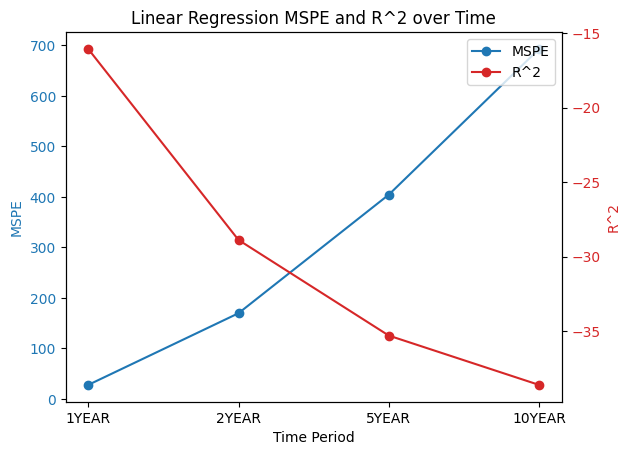

In [120]:
x_labels = ['1YEAR', '2YEAR', '5YEAR', '10YEAR']

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_lr, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_lr, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Linear Regression MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

### Penalized linear regressions (Ridge, Lasso, Elastic Net)



In [121]:
mspe_ridge = []
r2_ridge = []

In [122]:
model_ridge = Ridge()
model_lasso = Lasso()

#### 1 YEAR

In [123]:
predict_ridge_1year = predict(data, model_ridge, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ridge_1year = r2_oos(np.array(data['1YEAR']), np.array(predict_ridge_1year[forecast_start:]))

print('R2:', r2_oos_ridge_1year)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_ridge_1year))
print('MSPE:', mspe)
mspe_ridge.append(mspe)
r2_ridge.append(*r2_oos_ridge_1year)

R2: [-2.5643549]
MSPE: 4.64708965140499


#### 2 YEAR

In [124]:
predict_ridge_2year = predict(data, model_ridge, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ridge_2year = r2_oos(np.array(data['2YEAR']), np.array(predict_ridge_2year[forecast_start:]))

print('R2:', r2_oos_ridge_2year)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_ridge_2year))
print('MSPE:', mspe)
mspe_ridge.append(mspe)
r2_ridge.append(*r2_oos_ridge_2year)

R2: [-4.23774051]
MSPE: 19.808727172886172


#### 5 YEAR

In [125]:
predict_ridge_5year = predict(data, model_ridge, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ridge_5year = r2_oos(np.array(data['5YEAR']), np.array(predict_ridge_5year[forecast_start:]))

print('R2:', r2_oos_ridge_5year)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_ridge_5year))
print('MSPE:', mspe)
mspe_ridge.append(mspe)
r2_ridge.append(*r2_oos_ridge_5year)

R2: [-3.4079271]
MSPE: 33.55367177743985


#### 10 YEAR

In [126]:
predict_ridge_10year = predict(data, model_ridge, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_ridge_10year = r2_oos(np.array(data['10YEAR']), np.array(predict_ridge_10year[forecast_start:]))

print('R2:', r2_oos_ridge_10year)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_ridge_10year))
print('MSPE:', mspe)
mspe_ridge.append(mspe)
r2_ridge.append(*r2_oos_ridge_10year)

R2: [-3.42478759]
MSPE: 51.893175468785756


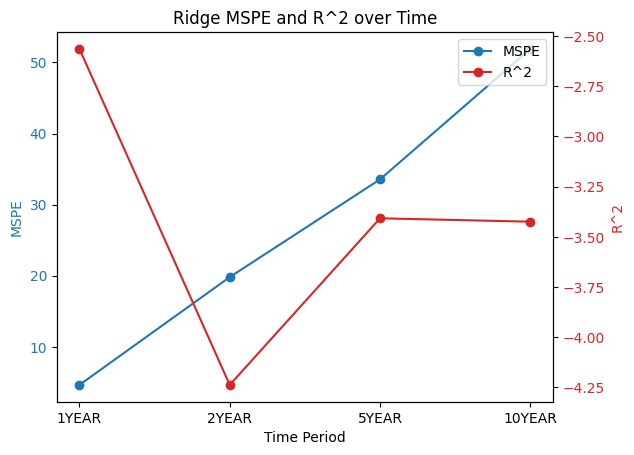

In [127]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_ridge, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_ridge, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Ridge MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

In [128]:
mspe_lasso = []
r2_lasso = []

#### 1 YEAR

In [129]:
predict_lasso_1year = predict(data, model_lasso, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_lasso_1year = r2_oos(np.array(data['1YEAR']), np.array(predict_lasso_1year[forecast_start:]))

print('R2:', r2_oos_lasso_1year)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_lasso_1year))
print('MSPE:', mspe)
mspe_lasso.append(mspe)
r2_lasso.append(*r2_oos_lasso_1year)

R2: [-0.04909379]
MSPE: 2.5778890087999606


#### 2 YEAR

In [130]:
predict_lasso_2year = predict(data, model_lasso, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_lasso_2year = r2_oos(np.array(data['2YEAR']), np.array(predict_lasso_2year[forecast_start:]))

print('R2:', r2_oos_lasso_2year)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_lasso_2year))
print('MSPE:', mspe)
mspe_lasso.append(mspe)
r2_lasso.append(*r2_oos_lasso_2year)

R2: [-0.23003408]
MSPE: 9.499474165860736


#### 5 YEAR

In [131]:
predict_lasso_5year = predict(data, model_lasso, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_lasso_5year = r2_oos(np.array(data['5YEAR']), np.array(predict_lasso_5year[forecast_start:]))

print('R2:', r2_oos_lasso_5year)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_lasso_5year))
print('MSPE:', mspe)
mspe_lasso.append(mspe)
r2_lasso.append(*r2_oos_lasso_5year)

R2: [-0.34415229]
MSPE: 18.96783246973582


#### 10 YEAR

In [132]:
predict_lasso_10year = predict(data, model_lasso, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_lasso_10year = r2_oos(np.array(data['10YEAR']), np.array(predict_lasso_10year[forecast_start:]))

print('R2:', r2_oos_lasso_10year)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_lasso_10year))
print('MSPE:', mspe)
mspe_lasso.append(mspe)
r2_lasso.append(*r2_oos_lasso_10year)

R2: [-0.37094069]
MSPE: 29.24640656387469


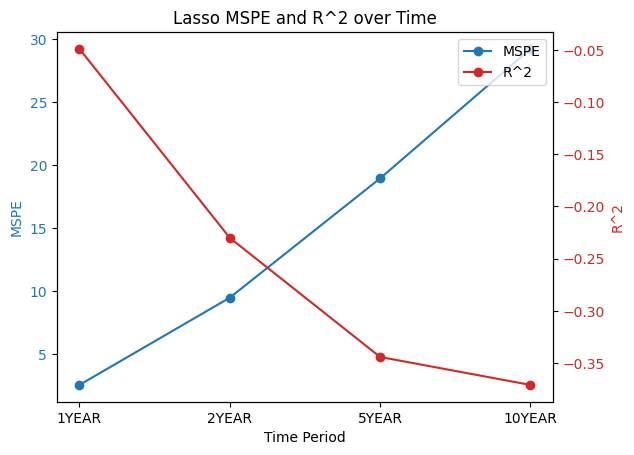

In [133]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_lasso, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_lasso, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Lasso MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

In [134]:
mspe_el_net = []
r2_el_net = []

In [135]:
model_el_net = ElasticNet()

#### 1 YEAR

In [136]:
predict_el_net_1year = predict(data, model_el_net, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_el_net_1year = r2_oos(np.array(data['1YEAR']), np.array(predict_el_net_1year[forecast_start:]))

print('R2:', r2_oos_el_net_1year)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_el_net_1year))
print('MSPE:', mspe)
mspe_el_net.append(mspe)
r2_el_net.append(*r2_oos_el_net_1year)

R2: [-0.07487715]
MSPE: 2.5768310979577724


#### 2 YEAR

In [137]:
predict_el_net_2year = predict(data, model_el_net, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_el_net_2year = r2_oos(np.array(data['2YEAR']), np.array(predict_el_net_2year[forecast_start:]))

print('R2:', r2_oos_el_net_2year)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_el_net_2year))
print('MSPE:', mspe)
mspe_el_net.append(mspe)
r2_el_net.append(*r2_oos_el_net_2year)

R2: [-0.22196182]
MSPE: 9.479553198077197


#### 5 YEAR

In [138]:
predict_el_net_5year = predict(data, model_el_net, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_el_net_5year = r2_oos(np.array(data['5YEAR']), np.array(predict_el_net_5year[forecast_start:]))

print('R2:', r2_oos_el_net_5year)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_el_net_5year))
print('MSPE:', mspe)
mspe_el_net.append(mspe)
r2_el_net.append(*r2_oos_el_net_5year)

R2: [-0.2767377]
MSPE: 18.781501344511664


#### 10 YEAR

In [139]:
predict_el_net_10year = predict(data, model_el_net, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_el_net_10year = r2_oos(np.array(data['10YEAR']), np.array(predict_el_net_10year[forecast_start:]))

print('R2:', r2_oos_el_net_10year)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_el_net_10year))
print('MSPE:', mspe)
mspe_el_net.append(mspe)
r2_el_net.append(*r2_oos_el_net_10year)

R2: [-0.30727962]
MSPE: 29.322363972766727


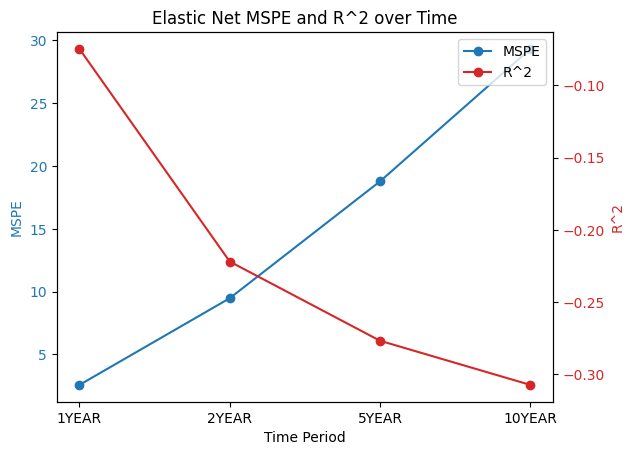

In [140]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_el_net, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_el_net, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elastic Net MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

#### Compare errors

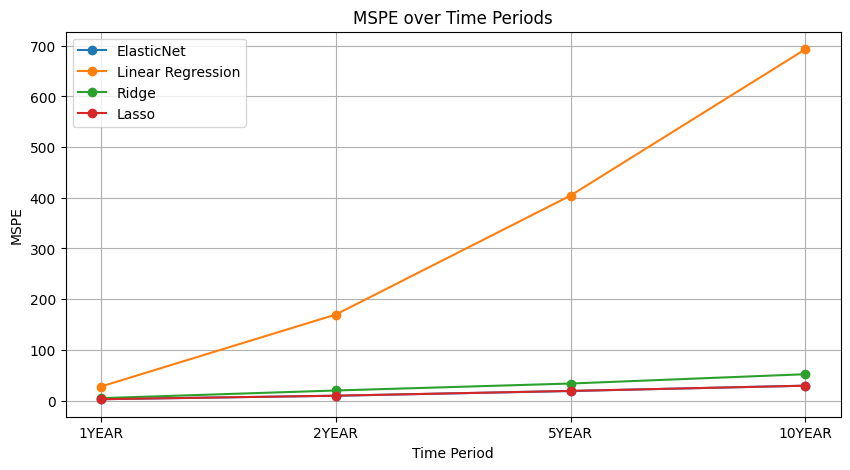

In [141]:
plt.figure(figsize=(10, 5))
plt.plot(x_labels, mspe_el_net, marker='o', label='ElasticNet')
plt.plot(x_labels, mspe_lr, marker='o', label='Linear Regression')
plt.plot(x_labels, mspe_ridge, marker='o', label='Ridge')
plt.plot(x_labels, mspe_lasso, marker='o', label='Lasso')
plt.xlabel('Time Period')
plt.ylabel('MSPE')
plt.title('MSPE over Time Periods')
plt.legend()
plt.grid(True)
plt.show()

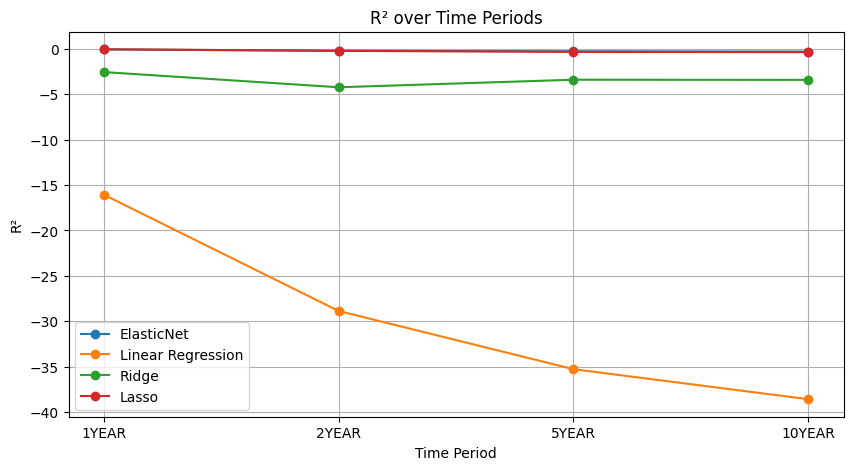

In [142]:
plt.figure(figsize=(10, 5))
plt.plot(x_labels, r2_el_net, marker='o', label='ElasticNet')
plt.plot(x_labels, r2_lr, marker='o', label='Linear Regression')
plt.plot(x_labels, r2_ridge, marker='o', label='Ridge')
plt.plot(x_labels, r2_lasso, marker='o', label='Lasso')
plt.xlabel('Time Period')
plt.ylabel('R²')
plt.title('R² over Time Periods')
plt.legend()
plt.grid(True)
plt.show()

### Principal component analysis (PCA) (3, 5 and 10 components)

In [143]:
def pca(data, y, num_components):
  if num_components == 3:
    predictors = PREDICTORS[:3]
    X = data[predictors[:5]]
  else:
    X = data[PREDICTORS]
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  pca = PCA(n_components=num_components)
  X_pca = pca.fit_transform(X_scaled)
  model = LinearRegression()
  data_1 = data.copy()
  if num_components == 3:
    data_1[predictors] = X_pca
  else:
    data_1[PREDICTORS[:5]] = X_pca
  prediction = predict(data_1, model, y, forecast_start, None, 'expanding', 0.85)
  return prediction

In [144]:
def print_r_and_mpse(prediction, term):
  r2 = r2_oos(np.array(data[term]), np.array(prediction[forecast_start:]))
  print('R2:', r2)
  mspe = calculate_mspe(np.array(data[term]), np.array(prediction))
  print('MSPE:', mspe)
  print('-'*100)

#### 1YEAR PCA

In [145]:
prediction_1year_5 = pca(data, '1YEAR', 5)
print_r_and_mpse(prediction_1year_5, '1YEAR')

R2: [-35.61712294]
MSPE: 29.564798229870533
----------------------------------------------------------------------------------------------------


#### 2YEAR PCA

In [146]:
prediction_2year_5 = pca(data, '2YEAR', 5)
print_r_and_mpse(prediction_2year_5, '2YEAR')

R2: [-71.75452424]
MSPE: 196.3175395057073
----------------------------------------------------------------------------------------------------


#### 5YEAR PCA

In [147]:
prediction_5year_5 = pca(data, '5YEAR', 5)
print_r_and_mpse(prediction_5year_5, '5YEAR')

R2: [-93.27572489]
MSPE: 476.5275860661119
----------------------------------------------------------------------------------------------------


#### 10YEAR PCA

In [148]:
prediction_10year_5 = pca(data, '10YEAR', 5)
print_r_and_mpse(prediction_10year_5, '10YEAR')

R2: [-103.76027145]
MSPE: 828.4318750083473
----------------------------------------------------------------------------------------------------


### Random forests

In [149]:
mspe_rf = []
r2_rf = []

In [150]:
model_rf = RandomForestRegressor()

#### 1YEAR

In [151]:
predict_rf_1year = predict(data, model_rf, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_rf_1year = r2_oos(np.array(data['1YEAR']), np.array(predict_rf_1year[forecast_start:]))

print('R2:', r2_oos_rf_1year)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_rf_1year))
print('MSPE:', mspe)
mspe_rf.append(mspe)
r2_rf.append(*r2_oos_rf_1year)

R2: [0.25146337]
MSPE: 2.31924771958562


#### 2YEAR

In [152]:
predict_rf_2year = predict(data, model_rf, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_rf_2year = r2_oos(np.array(data['2YEAR']), np.array(predict_rf_2year[forecast_start:]))

print('R2:', r2_oos_rf_2year)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_rf_2year))
print('MSPE:', mspe)
mspe_rf.append(mspe)
r2_rf.append(*r2_oos_rf_2year)

R2: [0.16777714]
MSPE: 8.173472705002453


#### 5YEAR

In [153]:
predict_rf = predict(data, model_rf, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_rf = r2_oos(np.array(data['5YEAR']), np.array(predict_rf[forecast_start:]))

print('R2:', r2_oos_rf)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_rf))
print('MSPE:', mspe)
mspe_rf.append(mspe)
r2_rf.append(*r2_oos_rf)

R2: [0.10438308]
MSPE: 16.11077279300226


#### 10YEAR

In [154]:
predict_rf = predict(data, model_rf, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_rf = r2_oos(np.array(data['10YEAR']), np.array(predict_rf[forecast_start:]))

print('R2:', r2_oos_rf)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_rf))
print('MSPE:', mspe)
mspe_rf.append(mspe)
r2_rf.append(*r2_oos_rf)

R2: [0.10996749]
MSPE: 24.928935856867078


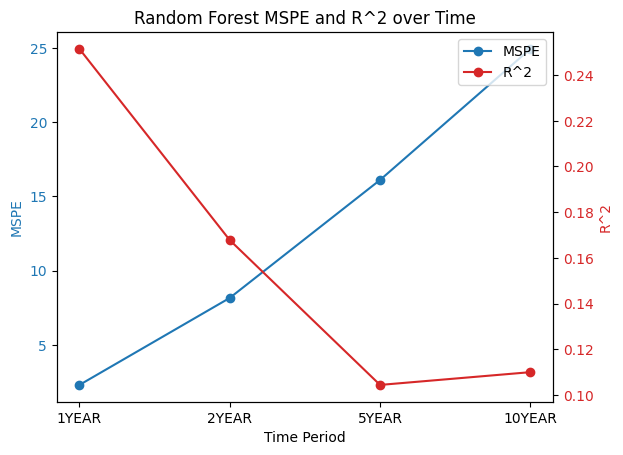

In [155]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_rf, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_rf, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Random Forest MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

### Boosted regression trees (XGBoost, AdaBoost)

In [156]:
mspe_xgb = []
r2_xgb = []

In [157]:
model_xgb = XGBRegressor()

#### 1YEAR

In [158]:
predict_xgb = predict(data, model_xgb, '1YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_xgb = r2_oos(np.array(data['1YEAR']), np.array(predict_xgb[forecast_start:]))

print('R2:', r2_oos_xgb)
mspe = calculate_mspe(np.array(data['1YEAR']), np.array(predict_xgb))
print('MSPE:', mspe)
mspe_xgb.append(mspe)
r2_xgb.append(*r2_oos_xgb)

R2: [0.31553825]
MSPE: 2.1943645556309486


#### 2YEAR

In [159]:
predict_xgb = predict(data, model_xgb, '2YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_xgb = r2_oos(np.array(data['2YEAR']), np.array(predict_xgb[forecast_start:]))

print('R2:', r2_oos_xgb)
mspe = calculate_mspe(np.array(data['2YEAR']), np.array(predict_xgb))
print('MSPE:', mspe)
mspe_xgb.append(mspe)
r2_xgb.append(*r2_oos_xgb)

R2: [0.13447571]
MSPE: 7.617525095373536


#### 5YEAR

In [160]:
predict_xgb = predict(data, model_xgb, '5YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_xgb = r2_oos(np.array(data['5YEAR']), np.array(predict_xgb[forecast_start:]))

print('R2:', r2_oos_xgb)
mspe = calculate_mspe(np.array(data['5YEAR']), np.array(predict_xgb))
print('MSPE:', mspe)
mspe_xgb.append(mspe)
r2_xgb.append(*r2_oos_xgb)

R2: [-0.02222417]
MSPE: 15.369508118851462


#### 10YEAR

In [161]:
predict_xgb = predict(data, model_xgb, '10YEAR', forecast_start, True, 'expanding', 0.85)

r2_oos_xgb = r2_oos(np.array(data['10YEAR']), np.array(predict_xgb[forecast_start:]))

print('R2:', r2_oos_xgb)
mspe = calculate_mspe(np.array(data['10YEAR']), np.array(predict_xgb))
print('MSPE:', mspe)
mspe_xgb.append(mspe)
r2_xgb.append(*r2_oos_xgb)

R2: [0.14312523]
MSPE: 23.98440455600639


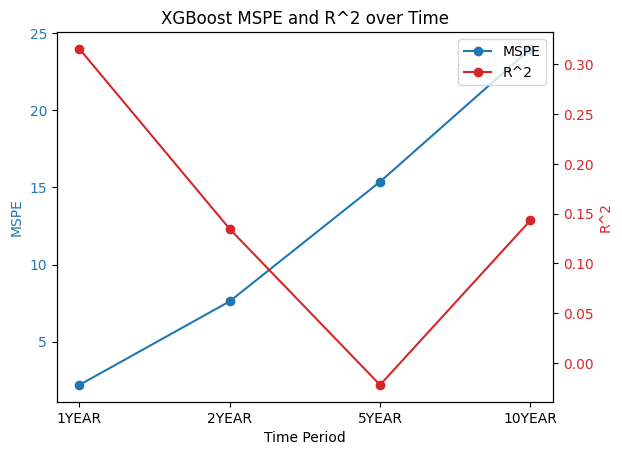

In [162]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time Period')
ax1.set_ylabel('MSPE', color=color)
ax1.plot(x_labels, mspe_xgb, color=color, marker='o', label='MSPE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('R^2', color=color)
ax2.plot(x_labels, r2_xgb, color=color, marker='o', label='R^2')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('XGBoost MSPE and R^2 over Time')

fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()

#### Compare errors

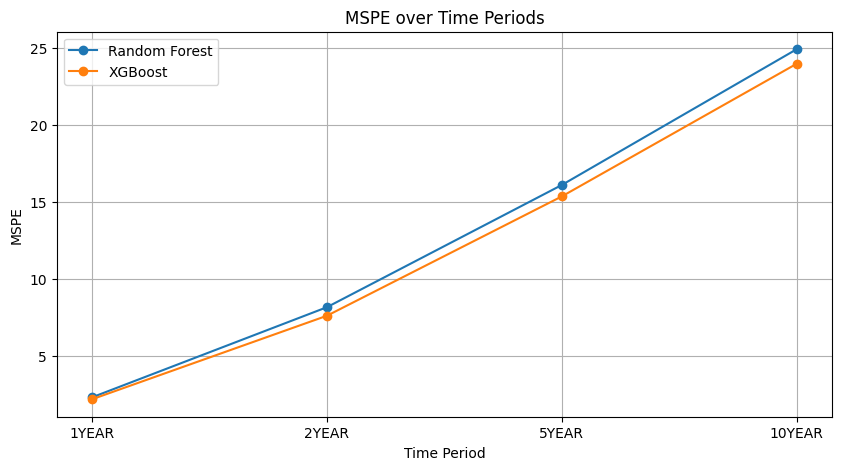

In [166]:
plt.figure(figsize=(10, 5))
plt.plot(x_labels, mspe_rf, marker='o', label='Random Forest')
plt.plot(x_labels, mspe_xgb, marker='o', label='XGBoost')
plt.xlabel('Time Period')
plt.ylabel('MSPE')
plt.title('MSPE over Time Periods')
plt.legend()
plt.grid(True)
plt.show()

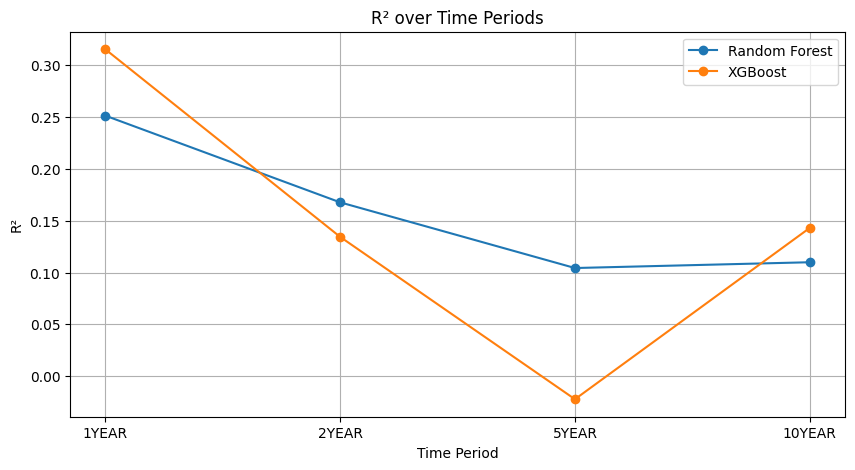

In [167]:
plt.figure(figsize=(10, 5))
plt.plot(x_labels, r2_rf, marker='o', label='Random Forest')
plt.plot(x_labels, r2_xgb, marker='o', label='XGBoost')
plt.xlabel('Time Period')
plt.ylabel('R²')
plt.title('R² over Time Periods')
plt.legend()
plt.grid(True)
plt.show()

### Neural networks: shallow vs. deep (1 layer with 16 nodes vs. 2 layers with 16-8 nodes)

In [168]:
split_ratio = 0.85
split_index = int(len(data) * split_ratio)

train_data = data.iloc[:split_index]
val_data = data.iloc[split_index:]

In [169]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)

In [170]:
X_train = train_scaled[:, 4:]
y_train_1YEAR = train_scaled[:, 0]
y_train_2YEAR = train_scaled[:, 1]
y_train_5YEAR = train_scaled[:, 2]
y_train_10YEAR = train_scaled[:, 3]



X_val = val_scaled[:, 4:]
y_val_1YEAR = val_scaled[:, 0]
y_val_2YEAR = val_scaled[:, 1]
y_val_5YEAR = val_scaled[:, 2]
y_val_10YEAR = val_scaled[:, 3]

In [171]:
def build_model(layers):
    model = Sequential()
    model.add(Dense(layers[0], input_dim=X_train.shape[1], activation='relu'))
    if len(layers) > 1:
        for units in layers[1:]:
            model.add(Dense(units, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

In [172]:
def train_and_predict_in_blocks(X_train, y_train, X_val, y_val, layers, reestimate_interval):
    num_val_points = len(X_val)
    predictions = []
    history_list = []

    for start in range(0, num_val_points, reestimate_interval):
        end = min(start + reestimate_interval, num_val_points)

        # Build and train the model
        model = build_model(layers)
        history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val[start:end], y_val[start:end]), verbose=0)

        # Predict for the current block
        predictions.extend(model.predict(X_val[start:end]))

        # Expand training set
        X_train = np.vstack((X_train, X_val[start:end]))
        y_train = np.hstack((y_train, y_val[start:end]))
        history_list.append(history)

    return np.array(predictions), history_list

In [173]:
reestimate_interval = 30


In [174]:
# Shallow Network (1 layer with 16 nodes)
shallow_layers = [16]
shallow_predictions_1YEAR, shallow_history_1YEAR = train_and_predict_in_blocks(X_train, y_train_1YEAR, X_val, y_val_1YEAR, shallow_layers, reestimate_interval)
shallow_predictions_2YEAR, shallow_history_2YEAR = train_and_predict_in_blocks(X_train, y_train_2YEAR, X_val, y_val_2YEAR, shallow_layers, reestimate_interval)
shallow_predictions_5YEAR, shallow_history_5YEAR = train_and_predict_in_blocks(X_train, y_train_5YEAR, X_val, y_val_5YEAR, shallow_layers, reestimate_interval)
shallow_predictions_10YEAR, shallow_history_10YEAR = train_and_predict_in_blocks(X_train, y_train_10YEAR, X_val, y_val_10YEAR, shallow_layers, reestimate_interval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [175]:
# Deep Network (2 layers with 16-8 nodes)
deep_layers = [16, 8]
deep_predictions_1YEAR, deep_history_1YEAR = train_and_predict_in_blocks(X_train, y_train_1YEAR, X_val, y_val_1YEAR, deep_layers, reestimate_interval)
deep_predictions_2YEAR, deep_history_2YEAR = train_and_predict_in_blocks(X_train, y_train_2YEAR, X_val, y_val_2YEAR, deep_layers, reestimate_interval)
deep_predictions_5YEAR, deep_history_5YEAR = train_and_predict_in_blocks(X_train, y_train_5YEAR, X_val, y_val_5YEAR, deep_layers, reestimate_interval)
deep_predictions_10YEAR, deep_history_10YEAR = train_and_predict_in_blocks(X_train, y_train_10YEAR, X_val, y_val_10YEAR, deep_layers, reestimate_interval)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [176]:
# Function to plot validation loss
def plot_validation_loss(history_list, title):
    val_loss = [hist.history['val_loss'][-1] for hist in history_list]
    plt.figure(figsize=(10, 6))
    plt.plot(val_loss, marker='o', label = 'validation loss by window')
    plt.title(title)
    plt.xlabel('Block Number')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [177]:
print("Shallow Network - 1YEAR MSPE:", calculate_mspe(y_val_1YEAR, shallow_predictions_1YEAR))
print("Shallow Network - 2YEAR MSPE:", calculate_mspe(y_val_2YEAR, shallow_predictions_2YEAR))
print("Shallow Network - 5YEAR MSPE:", calculate_mspe(y_val_5YEAR, shallow_predictions_5YEAR))
print("Shallow Network - 10YEAR MSPE:", calculate_mspe(y_val_10YEAR, shallow_predictions_10YEAR))

print("Deep Network - 1YEAR MSPE:", calculate_mspe(y_val_1YEAR, deep_predictions_1YEAR))
print("Deep Network - 2YEAR MSPE:", calculate_mspe(y_val_2YEAR, deep_predictions_2YEAR))
print("Deep Network - 5YEAR MSPE:", calculate_mspe(y_val_5YEAR, deep_predictions_5YEAR))
print("Deep Network - 10YEAR MSPE:", calculate_mspe(y_val_10YEAR, deep_predictions_10YEAR))

Shallow Network - 1YEAR MSPE: 0.9941703401018087
Shallow Network - 2YEAR MSPE: 0.38898064586223124
Shallow Network - 5YEAR MSPE: 0.6638206991523766
Shallow Network - 10YEAR MSPE: 0.7469844333055382
Deep Network - 1YEAR MSPE: 0.3023533470616389
Deep Network - 2YEAR MSPE: 0.18287602515891457
Deep Network - 5YEAR MSPE: 0.3274561063065149
Deep Network - 10YEAR MSPE: 0.4089336248084246


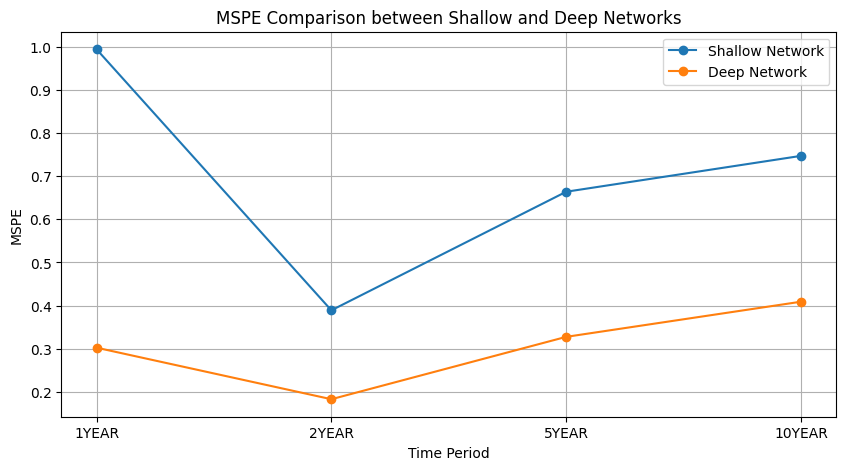

In [178]:
x_labels = ['1YEAR', '2YEAR', '5YEAR', '10YEAR']
mspe_shallow = [
    calculate_mspe(y_val_1YEAR, shallow_predictions_1YEAR),
    calculate_mspe(y_val_2YEAR, shallow_predictions_2YEAR),
    calculate_mspe(y_val_5YEAR, shallow_predictions_5YEAR),
    calculate_mspe(y_val_10YEAR, shallow_predictions_10YEAR)
]

mspe_deep = [
    calculate_mspe(y_val_1YEAR, deep_predictions_1YEAR),
    calculate_mspe(y_val_2YEAR, deep_predictions_2YEAR),
    calculate_mspe(y_val_5YEAR, deep_predictions_5YEAR),
    calculate_mspe(y_val_10YEAR, deep_predictions_10YEAR)
]

plt.figure(figsize=(10, 5))
plt.plot(x_labels, mspe_shallow, marker='o', label='Shallow Network')
plt.plot(x_labels, mspe_deep, marker='o', label='Deep Network')
plt.xlabel('Time Period')
plt.ylabel('MSPE')
plt.title('MSPE Comparison between Shallow and Deep Networks')
plt.legend()
plt.grid(True)
plt.show()

In [179]:
def r2_oos_updated(my_data, predict_model):
    sum1 = 0
    sum2 = 0
    window = len(my_data) - len(predict_model)

    for index in range(len(predict_model)):
        if index == 0:
            continue
        sum1 += np.square(my_data[index + window] - predict_model[index])
        sum2 += np.square(my_data[index + window] - np.mean(my_data[:index + window]))

    summary = 1 - sum1 / sum2
    return summary


In [180]:
print("Shallow Network - 1YEAR R² OOS:", r2_oos_updated(y_val_1YEAR, shallow_predictions_1YEAR))
print("Shallow Network - 2YEAR R² OOS:", r2_oos_updated(y_val_2YEAR, shallow_predictions_2YEAR))
print("Shallow Network - 5YEAR R² OOS:", r2_oos_updated(y_val_5YEAR, shallow_predictions_5YEAR))
print("Shallow Network - 10YEAR R² OOS:", r2_oos_updated(y_val_10YEAR, shallow_predictions_10YEAR))

print("Deep Network - 1YEAR R² OOS:", r2_oos_updated(y_val_1YEAR, deep_predictions_1YEAR))
print("Deep Network - 2YEAR R² OOS:", r2_oos_updated(y_val_2YEAR, deep_predictions_2YEAR))
print("Deep Network - 5YEAR R² OOS:", r2_oos_updated(y_val_5YEAR, deep_predictions_5YEAR))
print("Deep Network - 10YEAR R² OOS:", r2_oos_updated(y_val_10YEAR, deep_predictions_10YEAR))

Shallow Network - 1YEAR R² OOS: [-90.87793]
Shallow Network - 2YEAR R² OOS: [-9.41506]
Shallow Network - 5YEAR R² OOS: [-5.8814516]
Shallow Network - 10YEAR R² OOS: [-3.560905]
Deep Network - 1YEAR R² OOS: [-25.750948]
Deep Network - 2YEAR R² OOS: [-3.8142543]
Deep Network - 5YEAR R² OOS: [-3.099595]
Deep Network - 10YEAR R² OOS: [-1.7955189]


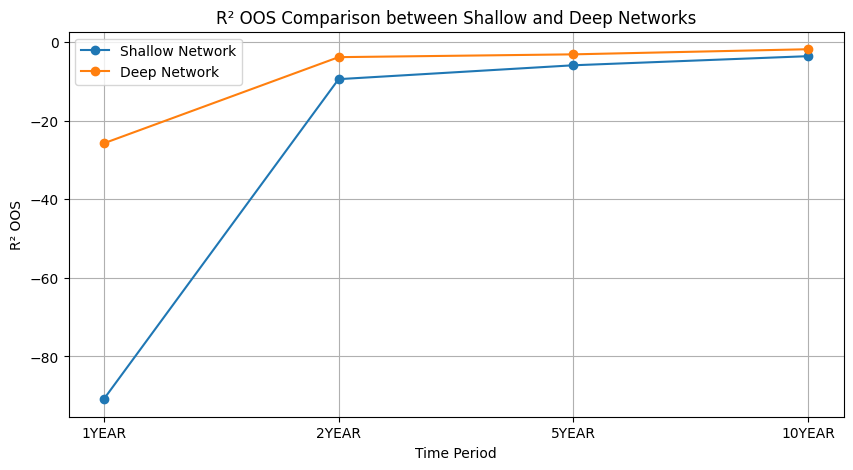

In [181]:
r2_shallow = [
    r2_oos_updated(y_val_1YEAR, shallow_predictions_1YEAR),
    r2_oos_updated(y_val_2YEAR, shallow_predictions_2YEAR),
    r2_oos_updated(y_val_5YEAR, shallow_predictions_5YEAR),
    r2_oos_updated(y_val_10YEAR, shallow_predictions_10YEAR)
]

r2_deep = [
    r2_oos_updated(y_val_1YEAR, deep_predictions_1YEAR),
    r2_oos_updated(y_val_2YEAR, deep_predictions_2YEAR),
    r2_oos_updated(y_val_5YEAR, deep_predictions_5YEAR),
    r2_oos_updated(y_val_10YEAR, deep_predictions_10YEAR)
]

plt.figure(figsize=(10, 5))
plt.plot(x_labels, r2_shallow, marker='o', label='Shallow Network')
plt.plot(x_labels, r2_deep, marker='o', label='Deep Network')
plt.xlabel('Time Period')
plt.ylabel('R² OOS')
plt.title('R² OOS Comparison between Shallow and Deep Networks')
plt.legend()
plt.grid(True)
plt.show()